In [1]:
# else
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.subplot.bottom'] = .1 

from mpl_toolkits.mplot3d import Axes3D # required for 3d plots
from matplotlib import cm # required for colors

import matplotlib.pyplot as plt
import time

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')

In [2]:
import numpy as np
from pymor.basic import *

In [3]:
set_log_levels({'notebook': 'INFO'})
logger = getLogger('notebook.notebook')

# Tutorial: Using pyMOR for PDE-constrained optimization problems

A typical application of model order reduction for PDEs are PDE-constrained parameter optimization problems. These problems typically aim to find a local minimizer of an objective functional. However, this functional underlies a PDE which needs to be solved for all evaluations of the objective functional. Mathematically speaking, for a physical domain $\Omega \subset \mathbb{R}^d$ and a parameter set $\mathcal{P} \subset \mathbb{R}^P$, we want to find a local minimizer $\mu \in \mathcal{P}$ of 

$$
\min_{\mu \in \mathcal{P}} J(u_{\mu}, \mu),  \tag{P.a}
$$
where $u_{\mu} \in V := H^1_0(\Omega)$ is the solution of

\begin{equation} \label{eq:primal}
a_{\mu}(u_{\mu}, v) = f_{\mu}(v) \qquad \forall \, v \in V \tag{P.b}
\end{equation}

The equation \eqref{eq:primal} is called the primal equation and can be arbitrariry complex. To MOR methods in the context of PDE-constrained optimization problems thus aims to find a surrogate model of \eqref{eq:primal} to reduce the computational costs of an evaluation of $J(u_{\mu}, \mu)$. 

Since $u_{\mu}$ is always related to $\mu$, we can also simplify of (P) by using the so-called reduced objective functional $\mathcal{J}(\mu):= J(u_{\mu}, \mu)$. Note that 'reduced' is not referring to the order of the model. We get the reduced optimization problem: Find a local minimizer of  

$$ 
\min_{\mu \in \mathcal{P}} \mathcal{J}(\mu),  \tag{$\hat{P}$}
$$

There exist plenty of different methods to solve ($\hat{P}$) by using MOR methods. Some of them rely on an RB method with traditional offline/online splitting, which typically result in a very online efficient approach. Recent reasearch also tackles overall efficiency by overcoming the expensive offline approach. 

In this tutorial, we use a simple linear objective functional and an elliptic primal equation to show different methods how to solve ($\hat{P}$).

## An elliptic model problem with a linear objective functional

We consider a domain $\Omega:= [-1, 1]^2$, a parameter set $\mathcal{P} := [0,\pi]^2$ and the elliptic equation

$$
- \nabla \cdot \big( \lambda_\mu \nabla u_\mu \big) = l
$$
with data functions

\begin{align}
l(x, y) &= \tfrac{1}{2} \pi^2 cos(\tfrac{1}{2} \pi x) cos(\tfrac{1}{2} \pi y),\\
\lambda(\mu) &= \theta_0(\mu) \lambda_0 + \theta_1(\mu) \lambda_1,\\
\theta_0(\mu) &= 1.1 + sin(\mu_0)\mu_1,\\
\theta_1(\mu) &= 1.1 + sin(\mu_1),\\
\lambda_0 &= \chi_{\Omega \backslash \omega},\\
\lambda_1 &= \chi_\omega,\\
\omega &:= [-\tfrac{2}{3}, -\tfrac{1}{3}]^2 \cup ([-\tfrac{2}{3}, -\tfrac{1}{3}] \times [\tfrac{1}{3}, \tfrac{2}{3}])
\end{align}

The diffusion is thus given as the linear combination of scaled indicator functions with support inside two blocks $\omega$ in the left half of the domain, roughly where the `w` is here:

```
+-----------+
|           |
|  w        |
|           |
|  w        |
|           |
+-----------+
```

From the definition above we can easily deduce the bilinear form $a_{\mu}$ and the linear functional $f_{\mu}$ for the primal equation. Moreover, we consider the linear objective functional
$$
\mathcal{J}(\mu) := \theta_{\mathcal{J}}(\mu)\, f_\mu(u_\mu) 
$$
where $\theta_{\mathcal{J}}(\mu) := 1 + \frac{1}{5}(\mu_0 + \mu_1)$.

With all these definitions, we can build a |StationaryProblem| in pyMOR. 

In [4]:
domain = RectDomain(([-1,-1], [1,1]))
indicator_domain = ExpressionFunction(
    '(-2/3. <= x[..., 0]) * (x[..., 0] <= -1/3.) * (-2/3. <= x[..., 1]) * (x[..., 1] <= -1/3.) * 1. \
   + (-2/3. <= x[..., 0]) * (x[..., 0] <= -1/3.) *  (1/3. <= x[..., 1]) * (x[..., 1] <=  2/3.) * 1.', 
    dim_domain=2, shape_range=())
rest_of_domain = ConstantFunction(1, 2) - indicator_domain
f = ExpressionFunction('0.5*pi*pi*cos(0.5*pi*x[..., 0])*cos(0.5*pi*x[..., 1])', dim_domain=2, shape_range=())

parameters = {'diffusion': 2}
thetas = [ExpressionParameterFunctional('1.1 + sin(diffusion[0])*diffusion[1]', parameters,
                                       derivative_expressions={'diffusion': ['cos(diffusion[0])*diffusion[1]',
                                                                             'sin(diffusion[0])']}),
          ExpressionParameterFunctional('1.1 + sin(diffusion[1])', parameters,
                                       derivative_expressions={'diffusion': ['0',
                                                                             'cos(diffusion[1])']}),

                                       ]
diffusion = LincombFunction([rest_of_domain, indicator_domain], thetas)

problem = StationaryProblem(domain, f, diffusion)

We now use the standard builtin discretization tool (see tutorial) to get a full order |StationaryModel|. Also, we define the parameter space $\mathcal{P}$ on which we want to optimize. 

In [5]:
fom, data = discretize_stationary_cg(problem, diameter=1/50)
parameter_space = fom.parameters.space(0, np.pi)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

So far we did not define an output for our FOM. pyMOR supports to choose an output functional in the model. Note that pyMOR also supports to give an output to |StationaryProblem| which also gets discretized by the discretizer. However, since we simply use the right hand side of the FOM, it is more convenient to define it after the discretization.

In [6]:
output_functional = fom.rhs.H
output_functional = LincombOperator([fom.rhs.H],
                                    [ExpressionParameterFunctional('1 + 1/5 * diffusion[0] + 1/5 * diffusion[1]', parameters,
                                       derivative_expressions={'diffusion': ['1/10',
                                                                             '1/10']})])
fom = fom.with_(output_functional=output_functional)

To overcome that pyMORs outputs return a |NumpyVectorArray|, we have to define a function that returns numpy arrays instead.

In [7]:
def fom_objective_functional(mu):
    return fom.output(mu).to_numpy()

Of course, all optimization methods need a certain starting parameter, which in our case is $\mu_0 = (0.25,0.5)$.

In [8]:
initial_guess = fom.parameters.parse([0.25, 0.5])

Next, we visualize the diffusion function $\lambda_\mu$, interpolated on the grid.

In [9]:
from pymor.discretizers.builtin.cg import InterpolationOperator

diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(initial_guess)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(initial_guess)

In [10]:
fom.visualize(diff)

Output()

In [11]:
print(data['grid'])

Tria-Grid on domain [-1,1] x [-1,1]
x0-intervals: 100, x1-intervals: 100
elements: 40000, edges: 60200, vertices: 20201


We can see that our FOM model has 20201 DoFs which just about suffices to resolve the data structure in the diffusion. This suggests to use an even finer mesh. However, for enabling a faster runtime for this tutorial, we stick with this mesh.

Before we start the first optimization method, we define helpful functions for visualizations that we use below.

In [12]:
def compute_value_matrix(f, x, y):
    f_of_x = np.zeros((len(x), len(y)))
    for ii in range(len(x)):
        for jj in range(len(y)):
            f_of_x[ii][jj] = f((x[ii], y[jj]))
    x, y = np.meshgrid(x, y)
    return x, y, f_of_x


def plot_3d_surface(f, x, y, alpha=1):
    X, Y = x, y
    cmaps = [plt.get_cmap(name) for name in ('Purples', 'Oranges', 'Blues')]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    if isinstance(f, (list, tuple)):
        for ii in range(len(f)):
            x, y, f_of_x = compute_value_matrix(f[ii], X, Y)
            ax.plot_surface(x, y, f_of_x, cmap=cmaps[ii%len(cmaps)],
                            linewidth=0, antialiased=False, alpha=alpha)
    else:
        x, y, f_of_x = compute_value_matrix(f, x, y)
        ax.plot_surface(x, y, f_of_x, cmap=cmaps[0],
                        linewidth=0, antialiased=False, alpha=alpha)
    ax.view_init(elev=27.7597402597, azim=-39.6370967742)
    ax.set_xlim3d([-0.10457963, 3.2961723])
    ax.set_ylim3d([-0.10457963, 3.29617229])
    return ax


def addplot_xy_point_as_bar(ax, x, y, color='orange', z_range=None):
    ax.plot([y, y], [x, x], z_range if z_range else ax.get_zlim(), color)

Now, we can visualize the objective functional on the parameter space

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

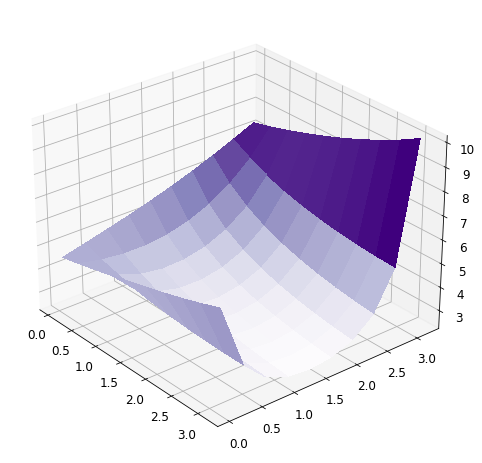

In [13]:
logger.info('plotting ...')

ranges = parameter_space.ranges['diffusion']
XX = np.linspace(ranges[0] + 0.05, ranges[1], 10)
YY = XX

plot_3d_surface(fom_objective_functional, XX, YY)

logger.info('... done')

In order to record some data in the optimization, we also define two helpful functions.

In [14]:
reference_minimization_data = {'num_evals': 0,
                               'evaluations' : [],
                               'evaluation_points': [],
                               'time': None}

def record_results(function, data, mu):
    print('.', end='')
    QoI = function(mu)
    data['num_evals'] += 1
    # we need to make sure to copy the data, since the added mu will be changed inplace by minimize afterwards
    data['evaluation_points'].append([fom.parameters.parse(mu)['diffusion'][:][0], 
                                      fom.parameters.parse(mu)['diffusion'][:][1]])
    data['evaluations'].append(QoI[0])
    return QoI

def report(result, data):
    if (result.status != 0):
        logger.info(' failed!')
    else:
        logger.info(' succeded!')
        logger.info('  mu_min:    {}'.format(fom.parameters.parse(result.x)))
        logger.info('  J(mu_min): {}'.format(result.fun[0]))
        logger.info('  num iterations:     {}'.format(result.nit))
        logger.info('  num function calls: {}'.format(data['num_evals']))
        logger.info('  time: {:.5f} seconds'.format(data['time']))
        if 'offline_time' in data:
            logger.info('  offline time: {:.5f} seconds'.format(data['offline_time']))

## Optimizing with the FOM model with finite differences

There exist plenty optimization methods and this tutorial is not meant to discuss the design and implementation of optimization methods. We simply use the `minimize` function from `scipy.optimize` and use the builtin `L-BFGS-B` function which is a quasi-Newton method which is also able to handle a constrained parameter space.

It is optional to give an expression for the gradient of the objective functional to the `minimize` function. In case no gradient is given, `minimize` just approximates the gradient with finite differences. This is not recommended because the gradient is inexact and the computation of finite difference require even more evalutations of the primal equation. 

In [15]:
from functools import partial
from scipy.optimize import minimize

tic = time.time()
fom_result = minimize(partial(record_results, fom_objective_functional, reference_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B', jac=False,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-15})
reference_minimization_data['time'] = time.time()-tic

.

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

...............................................

In [16]:
report(fom_result, reference_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

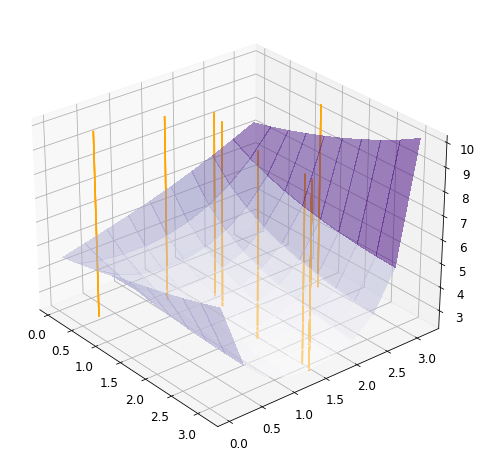

In [17]:
logger.info('plotting chosen points during minimization of reference quantity of interest ...')

reference_plot = plot_3d_surface(fom_objective_functional, XX, YY, alpha=0.5)

for mu in reference_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1])

logger.info('... done')

## Optimizing using a standard ROM model with finite differences

In [18]:
from pymor.algorithms.greedy import rb_greedy
from pymor.reductors.coercive import CoerciveRBReductor

# TODO: min-theta approach
# def coercivity_estimator(mu):
#    return 1./np.sqrt(alpha(grid_and_problem_data['lambda']['coefficients'], mu, mu_bar))

training_set = parameter_space.sample_uniformly(25)
training_set_simple = [mu['diffusion'] for mu in training_set]

RB_reductor = CoerciveRBReductor(
    fom, product=fom.h1_0_semi_product)

RB_greedy_data = rb_greedy(fom, RB_reductor, training_set)

num_RB_greedy_extensions = RB_greedy_data['extensions']
RB_greedy_mus, RB_greedy_errors = RB_greedy_data['max_err_mus'], RB_greedy_data['max_errs']

logger.info('RB system is of size {}x{}'.format(num_RB_greedy_extensions, num_RB_greedy_extensions))
logger.info('maximum estimated model reduction error over training set: {}'.format(RB_greedy_errors[-1]))

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Text(0, 0.5, 'max estimted relative error over training set')

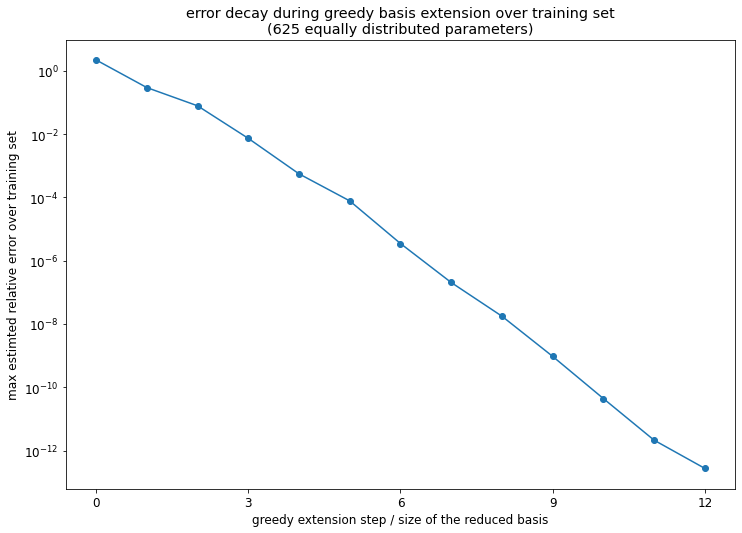

In [19]:
rom = RB_greedy_data['rom']
rom.disable_logging()

plt.plot(list(range(num_RB_greedy_extensions)) + [len(range(num_RB_greedy_extensions))],
         RB_greedy_errors,
         '-o')
plt.xticks(np.arange(0, num_RB_greedy_extensions + 1, 3))
plt.yscale('log')
plt.title('error decay during greedy basis extension over training set\n({} equally distributed parameters)'.format(len(training_set)))
plt.xlabel('greedy extension step / size of the reduced basis')
plt.ylabel('max estimated relative error over training set')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

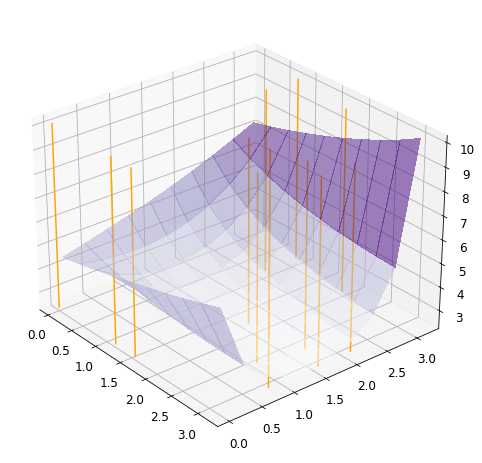

In [20]:
logger.info('plotting parameter values selected during the greedy ...')

fig = plt.figure()
ax = fig.gca(projection='3d')
x, y, f_of_x = compute_value_matrix(fom_objective_functional, XX, YY)
ax.plot_surface(x, y, f_of_x, cmap='Purples', linewidth=0, antialiased=False, alpha=0.5)
ax.view_init(elev=27.7597402597, azim=-39.6370967742)
ax.set_xlim3d([-0.10457963, 3.2961723])
ax.set_ylim3d([-0.10457963, 3.29617229])


for mu in RB_greedy_mus:
    mu = mu.to_numpy()
    addplot_xy_point_as_bar(ax, mu[0], mu[1])

logger.info('... done')

In [21]:
def rom_objective_functional(mu):
    return rom.output(mu).to_numpy()

RB_minimization_data = {'num_evals': 0,
                        'evaluations' : [],
                        'evaluation_points': [],
                        'time': np.inf,
                        'offline_time': RB_greedy_data['time']}

tic = time.time()
rom_result = minimize(partial(record_results, rom_objective_functional, RB_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B', jac=False,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-15})
RB_minimization_data['time'] = time.time()-tic

report(rom_result, RB_minimization_data)

..............................

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

## Optimizing using a gradient in FOM

In [22]:
from pdeopt_model import LinearPdeoptStationaryModel

opt_fom = LinearPdeoptStationaryModel(fom)

In [23]:
def fom_gradient_of_functional(mu):
    return opt_fom.output_functional_gradient(opt_fom.parameters.parse(mu))

opt_fom_minimization_data = {'num_evals': 0,
                            'evaluations' : [],
                            'evaluation_points': [],
                            'time': np.inf}
tic = time.time()
opt_fom_result = minimize(partial(record_results, fom_objective_functional, opt_fom_minimization_data),
                              initial_guess.to_numpy(),
                              method='L-BFGS-B', 
                              jac=fom_gradient_of_functional,
                              bounds=(ranges, ranges),
                              options={'ftol': 1e-15})
opt_fom_minimization_data['time'] = time.time()-tic
report(opt_fom_result, opt_fom_minimization_data)

.

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

........

## Optimizing using a gradient in ROM

In [24]:
opt_rom = LinearPdeoptStationaryModel(rom)

In [25]:
def rom_gradient_of_functional(mu):
    return opt_rom.output_functional_gradient(opt_rom.parameters.parse(mu))
            

opt_rom_minimization_data = {'num_evals': 0,
                             'evaluations' : [],
                             'evaluation_points': [],
                             'time': np.inf,
                             'offline_time': RB_greedy_data['time']}


tic = time.time()
opt_rom_result = minimize(partial(record_results, rom_objective_functional, opt_rom_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B', 
                  jac=rom_gradient_of_functional,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-15})
opt_rom_minimization_data['time'] = time.time()-tic
report(opt_rom_result, opt_rom_minimization_data)

.........

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

## An RB space with dual information

In [26]:
logger.info('reducing with dual extended RB ...')
logger.info('')

from pdeopt_greedy import pdeopt_greedy
from pdeopt_reductor import LinearPdeoptStationaryCoerciveRBReductor

# TODO: min-theta approach
# def coercivity_estimator(mu):
#    return 1./np.sqrt(alpha(grid_and_problem_data['lambda']['coefficients'], mu, mu_bar))

pdeopt_reductor = LinearPdeoptStationaryCoerciveRBReductor(
    opt_fom, product=opt_fom.h1_0_semi_product)

pdeopt_greedy_data = pdeopt_greedy(opt_fom, pdeopt_reductor, training_set)

num_RB_greedy_extensions = pdeopt_greedy_data['extensions']
RB_greedy_mus, RB_greedy_errors = pdeopt_greedy_data['max_err_mus'], pdeopt_greedy_data['max_errs']

logger.info('RB system is of size {}x{}'.format(num_RB_greedy_extensions, num_RB_greedy_extensions))
logger.info('maximum estimated model reduction error over training set: {}'.format(RB_greedy_errors[-1]))

logger.info('')
logger.info('... done')

rom_with_dual = pdeopt_greedy_data['rom']

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

My basis size is 1
My basis size is 2
My basis size is 3
My basis size is 4
My basis size is 5
My basis size is 6
My basis size is 7
My basis size is 8
My basis size is 9
My basis size is 10
My basis size is 11
My basis size is 12
My basis size is 12


In [27]:
opt_rom_with_dual = LinearPdeoptStationaryModel(rom)

In [28]:
def rom_objective_functional(mu):
    return opt_rom_with_dual.output(mu).to_numpy()

def rom_gradient_of_functional(mu):
    return opt_rom_with_dual.output_functional_gradient(opt_rom_with_dual.parameters.parse(mu))
            

opt_rom_with_dual_minimization_data = {'num_evals': 0,
                                       'evaluations' : [],
                                       'evaluation_points': [],
                                       'time': np.inf,
                                       'offline_time': pdeopt_greedy_data['time']}


tic = time.time()
rom_with_dual_result = minimize(partial(record_results, rom_objective_functional, 
                                        opt_rom_with_dual_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B', 
                  jac=rom_gradient_of_functional,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-15})
opt_fom_minimization_data['time'] = time.time()-tic
report(rom_with_dual_result, opt_rom_minimization_data)

.........

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

## Breaking the traditional offline/online splitting: enrich along the path of optimization

In [36]:
pdeopt_reductor = LinearPdeoptStationaryCoerciveRBReductor(
    opt_fom, product=opt_fom.h1_0_semi_product)

In [37]:
def record_results_and_enrich(function, data, mu):
    print('.', end='')
    try:
        pdeopt_reductor.extend_basis(mu)
    except:
        logger.info('Extension failed')
    opt_rom = pdeopt_reductor.reduce()
    QoI = function(mu)
    data['num_evals'] += 1
    # we need to make sure to copy the data, since the added mu will be changed inplace by minimize afterwards
    data['evaluation_points'].append([fom.parameters.parse(mu)['diffusion'][:][0], 
                                      fom.parameters.parse(mu)['diffusion'][:][1]])
    data['evaluations'].append(QoI[0])
    return QoI

def rom_objective_functional(mu):
    return opt_rom.output(mu).to_numpy()

def rom_gradient_of_functional(mu):
    return opt_rom.output_functional_gradient(opt_rom.parameters.parse(mu))

In [38]:
opt_along_path_minimization_data = {'num_evals': 0,
                                       'evaluations' : [],
                                       'evaluation_points': [],
                                       'time': np.inf}

tic = time.time()
opt_along_path_result = minimize(partial(record_results_and_enrich, rom_objective_functional, 
                                         opt_along_path_minimization_data),
                                  initial_guess.to_numpy(),
                                  method='L-BFGS-B', jac=rom_gradient_of_functional,
                                  bounds=(ranges, ranges),
                                  options={'ftol': 1e-15})
opt_along_path_minimization_data['time'] = time.time()-tic

.

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

My basis size is 1
.My basis size is 2
.My basis size is 3
.My basis size is 4
.My basis size is 5
.My basis size is 6
.My basis size is 7
.My basis size is 8
.My basis size is 8


In [39]:
report(opt_along_path_result, opt_along_path_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [33]:
report(fom_result, reference_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [34]:
report(opt_rom_result, opt_rom_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…